First figure of the manuscript, introductory. 
- examples of raw traces (both LFP and gamma) during wake and sleep.
- associated ACF and PSD during sleep stages
- accompanying fits on the functions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import mne
import nibabel as nib

import mni_utils as uti
from mni_plots import plot_parcellated_metric, half_violin_plot, plot_corr

Paths and names:

In [3]:
data_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
tau_path = data_path.joinpath("Results_acf_fit_exp")
fig_path = data_path.joinpath("Figures")

Parcellation:

In [4]:
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "HCPMMP1"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
parc_labels, ctab, parc_names = nib.freesurfer.read_annot(annot_file)

### A) Plot of parcellated brain areas

In [5]:
df_plot = {
    stage: pd.read_csv(tau_path.joinpath(f"tau_parc_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

In [8]:
minmax_stages = {"W": (15, 80), "N3": (90, 200), "R": (30, 110)}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Loop through stages
for stage in ["W", "N3", "R"]:

    fig, ax = plot_parcellated_metric(
        df_plot[stage].to_numpy().squeeze(),
        parc_labels,
        subjects_dir,
        log_scale=False,
        minmax=minmax_stages[stage],
        title="LFP timescales in " + title_dict[stage],
        cmap="inferno",
    )
    # plt.show()

    fig.savefig(fig_path.joinpath(f"Fig1_tau_parc_{stage}.png"), dpi=300)
    plt.close(fig)

### B) Maps of differences

In [9]:
df_plot_W_N3 = df_plot["N3"] - df_plot["W"]  # [20, 85]
df_plot_W_R = df_plot["R"] - df_plot["W"]  # [-5, 30]

# NREM3 figure
fig, ax = plot_parcellated_metric(
    df_plot_W_N3.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    log_scale=False,
    minmax=(50, 150),
    zero_center=False,
    title="NREM3 - Wake",
    cmap="Reds",
    label="Timescale difference [ms]",
)
fig.savefig(fig_path.joinpath(f"Fig1_tau_parc_N3-W.png"), dpi=300)
plt.close(fig)

# REM figure
fig, ax = plot_parcellated_metric(
    df_plot_W_R.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    log_scale=False,
    minmax=(-15, 70),
    zero_center=False,
    title="REM - Wake",
    cmap="Reds",
    label="Timescale difference [ms]",
)
fig.savefig(fig_path.joinpath(f"Fig1_tau_parc_R-W.png"), dpi=300)
plt.close(fig)

### C) Average increase of tau during sleep

In [ ]:
# TODO: compute average tau for each patient and stage : how to compute statistic ??

### D) Correlation with structure

Load T1w/T2w data and the centroids coordinates of the parcellation:

In [6]:
df_struct = pd.read_csv(data_path.joinpath("df_structural_avg.csv"), index_col=0)
map_coords = pd.read_csv(data_path.joinpath("mmp_centroids_coords.csv"), index_col=0)

Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


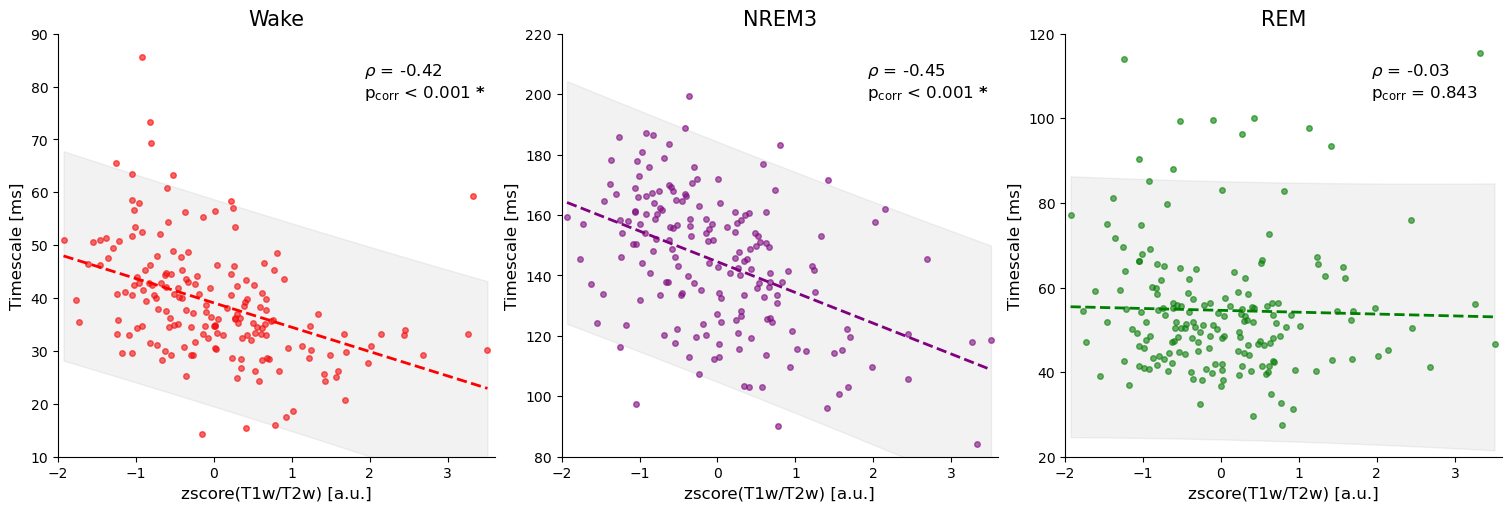

In [7]:
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}
color_stages = {"W": "red", "N3": "purple", "R": "green"}
xlims_stages = {"W": (-2, 3.6), "N3": (-2, 3.6), "R": (-2, 3.6)}
ylims_stages = {"W": (10, 90), "N3": (80, 220), "R": (20, 120)}

fig, axs = plt.subplots(1, 3, figsize=(15, 5), layout="constrained")

rhos, p_corrs, rhos_boot = {}, {}, {}

for i, stage in enumerate(["W", "N3", "R"]):
    # Import dataframe
    df_metric = df_plot[stage].copy()

    # Get data
    x = zscore(df_struct["T1T2"], ddof=1).to_numpy()
    y = df_metric.loc[df_struct.index].to_numpy().squeeze()

    # Get correlation values
    rho, p_corr = uti.get_pcorr(x, y, map_coords, method="vasa", corr_type="pearson")
    rho_boot = uti.get_rho_boot(x, y, corr_type="pearson", nboot=1000)
    rhos[stage] = rho
    p_corrs[stage] = p_corr
    rhos_boot[stage] = rho_boot

    # Plot
    axs[i] = plot_corr(
        axs[i],
        x,
        y,
        rho,
        p_corr,
        color=color_stages[stage],
        title=title_dict[stage],
        xlabel="zscore(T1w/T2w) [a.u.]",
        ylabel="Timescale [ms]",
        xlims=xlims_stages[stage],
        ylims=ylims_stages[stage],
    )

# Save figure
fig.savefig(
    fig_path.joinpath(f"Fig1_tau_corr_struct.png"),
    dpi=300,
    bbox_inches="tight",
)

plt.show()

### E) Correlation with structure as bar plot

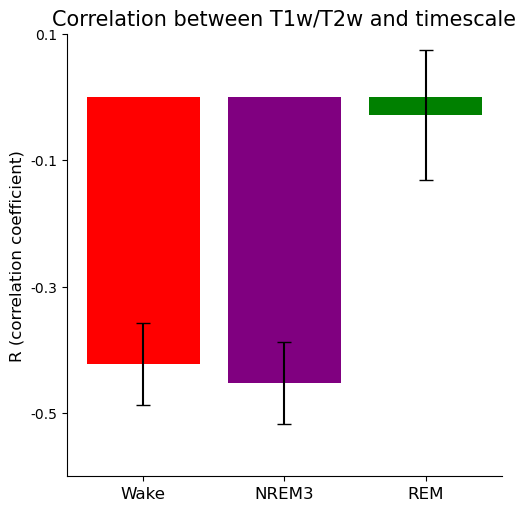

In [29]:
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}
color_stages = {"W": "red", "N3": "purple", "R": "green"}

fig, ax = plt.subplots(figsize=(5,5), layout="constrained")

ax.bar(
    x=[0, 1, 2],
    height=[rhos[stage] for stage in ["W", "N3", "R"]],
    color=[color_stages[stage] for stage in ["W", "N3", "R"]],
    yerr=[rhos_boot[stage].standard_error for stage in ["W", "N3", "R"]],
    capsize=5,
    
)
ax.set_xticks([0, 1, 2], labels=["Wake", "NREM3", "REM"], fontsize=12)
ax.set_ylim(-0.6, 0.1)
ax.set_yticks([-0.5, -0.3, -0.1, 0.1], labels=[-0.5, -0.3, -0.1, 0.1], fontsize=10)
ax.set_ylabel("R (correlation coefficient)", fontsize=12)
ax.set_title("Correlation between T1w/T2w and timescale", fontsize=15)
ax.spines[["top", "right"]].set_visible(False)



plt.show()

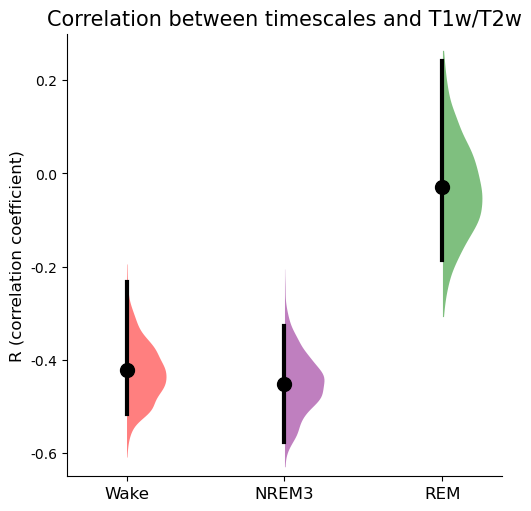

In [17]:
fig, ax = plt.subplots(figsize=(5,5), layout="constrained")

for i, stage in enumerate(["W", "N3", "R"]):
    half_violin_plot(
        ax,
        rhos[stage],
        x_pos=i,
        ci=list(rhos_boot[stage].confidence_interval),
        y_boot=rhos_boot[stage].bootstrap_distribution,
        color=color_stages[stage],
    )

ax.set_xticks([0, 1, 2], labels=["Wake", "NREM3", "REM"], fontsize=12)
ax.set_ylim(-0.65, 0.3)
ax.set_yticks([-0.6, -0.4, -0.2, 0., 0.2], labels=[-0.6, -0.4, -0.2, 0., 0.2], fontsize=10)
ax.set_ylabel("R (correlation coefficient)", fontsize=12)
ax.set_title("Correlation between timescales and T1w/T2w", fontsize=15)
ax.spines[["top", "right"]].set_visible(False)

plt.show()